### Data Science Essentials 4

**TN Med Helper** is a fictional company whose mission is to ensure access to healthcare for all Tennesseans. TN Med Helper has approached your data science consultancy for help identifying communities in Tennessee that need the most help in expanding access to healthcare.

In this project, we will use the [Medicare Disparities](https://data.cms.gov/mapping-medicare-disparities) data as a starting point for identifying such communities. Specifically, you will be provided with datasets containing the percent of Medicare beneficiaries who had an annual wellness visit (annual_wellness.csv), the number of all-cause hospitilizations per 1000 beneficiaries (hospitalizations.csv), and the number of emergency department visits per 1000 beneficiaries (emergency_department.csv). Over the next 8 weeks, you will work towards addressing the following three objectives.

First, TN Med Helper is concerned about communities either lacking access to healthcare or losing access to healthcare. They are looking to expand telehealth technologies into the vulnerable communities, and need your help to priortize areas most needing attention. your first objective is to identify which counties in Tennessee have the most severe lack of access to healthcare (either due to lack of hospitals, physicians, or both). Once you have identified these counties, see if you can find any common demographic or economic characteristics for these areas.

Second, TN Med Helper is interested in reducing the number of potentially preventable hospitalizations. Do areas that lack access to healthcare tend to have higher rates of emergency department visits or hospitalizations? Is there an association between the percentage of beneficiaries who had an annual wellness visit and rate of hospitalizations or emergency department visits?

Finally, TN Med Helper is trying to identify specific subpopulations to focus more attention on. Using data from [the Behavioral Risk Factor Surveillance System](https://www.cdc.gov/brfss/index.html), build a model to predict whether an individual has not had a checkup in the last year. Apply this model to the counties you identified above to predict how likely it is that the average person from those counties has not had a checkup in the last year. Which groups within these counties might need to be focused on to maximize the impact of TN Med Helper's efforts?

In [367]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from cm import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from cm import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [368]:
# Read in data files for Question 1
physicians = pd.read_csv('../data/primary_care_physicians.csv')
physicians = physicians.loc[physicians['state'] == 'Tennessee']
population = pd.read_csv('../data/population_by_county.csv')
population = population.loc[population['state'] == 'TENNESSEE']
hospitals = pd.read_csv('../data/Hospitals.csv')
hospitals = hospitals.loc[hospitals['STATE'] == 'TN']
unemployment = pd.read_csv('../data/tn_unemployment.csv')
# may also add closures-database, county health rankings

# Read in data files for Question 2
wellness = pd.read_csv('../data/Medicare_Disparities_by_Population/annual_wellness.csv')
wellness = wellness.loc[wellness['state'] == 'TENNESSEE']
hospitalizations = pd.read_csv('../data/Medicare_Disparities_by_Population/hospitalizations.csv')
hospitalizations = hospitalizations.loc[hospitalizations['state'] == 'TENNESSEE']
er_visits = pd.read_csv('../data/Medicare_Disparities_by_Population/emergency_department.csv')
er_visits = er_visits.loc[er_visits['state'] == 'TENNESSEE']

# Read in data files for Question 3
brfss = pd.read_csv('../data/brfss.csv')

Identify which counties in Tennessee have the most severe lack of access to healthcare (either due to lack of hospitals, physicians, or both)

In [369]:
# Correct column variables and merge data files; create new coluumn for residents per pcp
population['county'] = population['county'].str.lower() # make all county names lower case
population['county'] = population['county'].str.split(' county', expand = True)[0]

physicians['county'] = physicians['county'].str.lower() # make all county names lower case

physicians = pd.merge(left = physicians,
         right = population[['county','population', 'urban']])
physicians['residents_per_pcp'] = physicians['population'] / physicians['primary_care_physicians']

# Create categories for level of care
# Use .loc to add column, picks the new shadac category based on value in 'residents_per_pcp'
physicians.loc[physicians['residents_per_pcp'] < 1500, 'shadac_category'] = 'adequate'
physicians.loc[(physicians['residents_per_pcp'] >= 1500) & 
       (physicians['residents_per_pcp'] < 3500), 'shadac_category'] = 'moderately inadequate'
physicians.loc[(physicians['residents_per_pcp'] >= 3500), 'shadac_category'] = 'low inadequate'

# Return counties where shadac category is low inadequate for residents_per_pcp
Lack_of_Physicians = physicians.loc[(physicians['shadac_category'] == 'low inadequate')]

In [370]:
# Merge hospitals and physicians data frames
# Correct column variables and merge data files; create new coluumn for residents per hospital
hospitals['COUNTY'] = hospitals['COUNTY'].str.lower() # make all county names lower case

# take the value counts for number of hospitals per county
hospitals_df = hospitals['COUNTY'].value_counts().rename_axis('county').reset_index(name='hospitals')
physicians = pd.merge(physicians, hospitals_df, on='county', how='left').fillna(0)

In [371]:
# Create categories for level of care
# Use .loc to add column, picks the new shadac category based on value in 'residents_per_pcp'
physicians.loc[physicians['hospitals'] > 10, 'hos_per_county'] = 'adequate'
physicians.loc[(physicians['hospitals'] <= 10) & 
       (physicians['hospitals'] > 1), 'hos_per_county'] = 'moderately inadequate'
physicians.loc[(physicians['hospitals'] <= 1), 'hos_per_county'] = 'low inadequate'

# Return counties where hos_per_county is low inadequate for residents_per_pcp
Lack_of_Hospitals = physicians.loc[(physicians['hos_per_county'] == 'low inadequate')]

In [372]:
# Work with unemployment file, merge with physicians file
unemployment['Name'] = unemployment['Name'].str.lower()
unemployment['Name'] = unemployment['Name'].str.split(' county', expand = True)[0]
physicians = pd.merge(left = physicians,
         right = unemployment[['Name', 'unemployment_rate']].rename(columns = {'Name': 'county'}))

In [373]:
# Identify which counties in Tennessee have the most severe lack of access to healthcare (lack of hospitals & physicians)
lack_of_healthcare = physicians.loc[(physicians['hos_per_county'] == 'low inadequate') & 
                                    (physicians['shadac_category'] == 'low inadequate')]
lack_of_healthcare

,FIPS,state,county,primary_care_physicians,population,urban,residents_per_pcp,shadac_category,hospitals,hos_per_county,unemployment_rate
2,47005,Tennessee,benton,3.0,16140,Rural,5.380000e+03,low inadequate,1.0,low inadequate,6.2
3,47007,Tennessee,bledsoe,1.0,14836,Rural,1.483600e+04,low inadequate,1.0,low inadequate,7.2
7,47015,Tennessee,cannon,3.0,14178,Urban,4.726000e+03,low inadequate,1.0,low inadequate,4.4
11,47023,Tennessee,chester,4.0,17190,Urban,4.297500e+03,low inadequate,0.0,low inadequate,4.3
13,47027,Tennessee,clay,2.0,7654,Rural,3.827000e+03,low inadequate,1.0,low inadequate,6.8
16,47033,Tennessee,crockett,0.0,14399,Rural,inf,low inadequate,0.0,low inadequate,5.0
28,47057,Tennessee,grainger,5.0,23101,Urban,4.620200e+03,low inadequate,0.0,low inadequate,5.6
30,47061,Tennessee,grundy,0.0,13344,Rural,inf,low inadequate,0.0,low inadequate,6.5
33,47067,Tennessee,hancock,1.0,6587,Rural,6.587000e+03,low inadequate,1.0,low inadequate,6.7
34,47069,Tennessee,hardeman,4.0,25443,Rural,6.360750e+03,low inadequate,1.0,low inadequate,7.3


Once you have identified these counties, see if you can find any common demographic or economic characteristics for these areas.

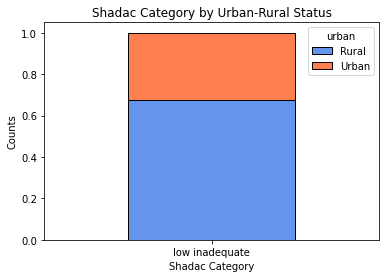

In [374]:
# Plot urban vs rural for low inadequate vs adquate areas
# this is not normalized crosstab -- just using raw values
pd.crosstab(lack_of_healthcare['shadac_category'], lack_of_healthcare['urban'],  normalize = 'index').plot(kind = 'bar', 
                                                          stacked = True,       # stacked as opposed to side-by-side
                                                          color = ['cornflowerblue', 'coral', 'pink'],     # change the default colors
                                                          edgecolor = 'black')              # add a border to the bars
plt.title('Shadac Category by Urban-Rural Status')                   # add a title
plt.xlabel('Shadac Category')
plt.ylabel('Counts')
plt.xticks(rotation = 0);                                             # change the appearance of the x tick labels

In [375]:
# Plot hos_per_county for low inadequate vs adquate areas
physicians.groupby('hos_per_county')['unemployment_rate'].mean()

hos_per_county
adequate                 5.125000
low inadequate           5.632857
moderately inadequate    5.028571
Name: unemployment_rate, dtype: float64

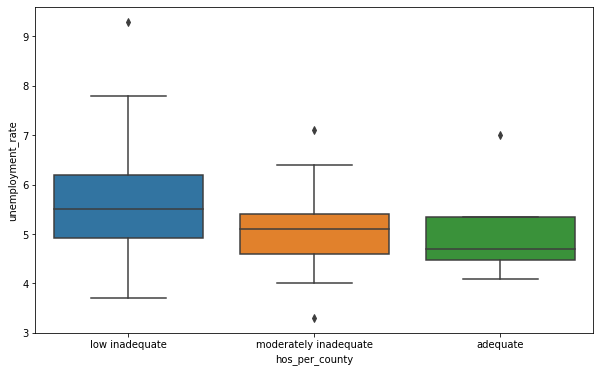

In [376]:
# Make boxplot
plt.figure(figsize = (10,6))

sns.boxplot(data = physicians,
           x = 'hos_per_county',
           y = 'unemployment_rate');

Second, TN Med Helper is interested in reducing the number of potentially preventable hospitalizations. Do areas that lack access to healthcare tend to have higher rates of emergency department visits or hospitalizations? 

In [377]:
# Merge hospitals and physicians data frames
# Correct column variables and merge data files; create new coluumn for residents per hospital
hospitalizations['county'] = hospitalizations['county'].str.lower() # make all county names lower case
hospitalizations['county'] = hospitalizations['county'].str.split(' county', expand = True)[0]

# Make new data frame with hopsital information
physicians = pd.merge(left = physicians, right = hospitalizations[['county','analysis_value']]
                      .rename(columns = {'analysis_value': 'hospit_1000'}))

In [378]:
# Correct column variables and merge data files; create new coluumn for residents per hospital
er_visits['county'] = er_visits['county'].str.lower() # make all county names lower case
er_visits['county'] = er_visits['county'].str.split(' county', expand = True)[0]

# Make new data frame with hopsital information
physicians = pd.merge(left = physicians, right = er_visits[['county','analysis_value']]
                      .rename(columns = {'analysis_value': 'ER_visits'}))

In [379]:
physicians.loc[(physicians['hos_per_county'] == 'low inadequate') & 
               (physicians['shadac_category'] == 'low inadequate'), 'status'] = 'inadequate'
physicians.loc[(physicians['hos_per_county'] != 'low inadequate') & 
               (physicians['shadac_category'] == 'low inadequate') | 
                (physicians['hos_per_county'] == 'low inadequate') & 
                (physicians['shadac_category'] != 'low inadequate') | 
                (physicians['hos_per_county'] != 'low inadequate') & 
                (physicians['shadac_category'] != 'low inadequate'), 'status'] = 'adequate'

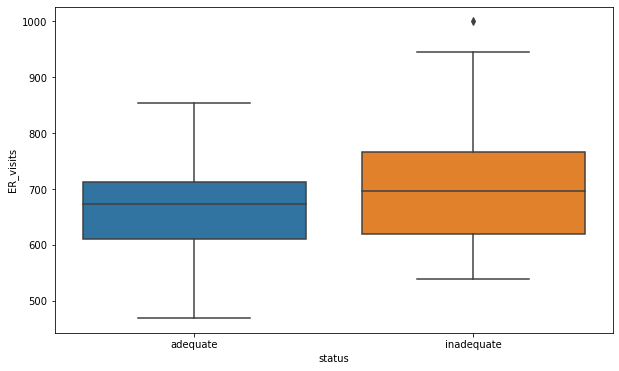

In [380]:
# Make boxplot for ER visits
plt.figure(figsize = (10,6))

sns.boxplot(data = physicians,
           x = 'status',
           y = 'ER_visits');

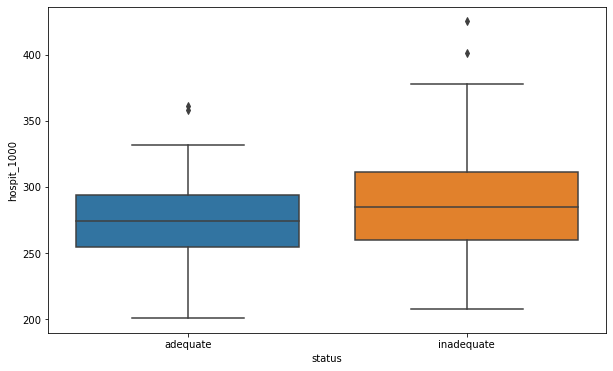

In [381]:
# Make boxplot for hospitilizations
plt.figure(figsize = (10,6))

sns.boxplot(data = physicians,
           x = 'status',
           y = 'hospit_1000');

In [382]:
# Find way to descriptive data means for these two groups
#lack_of_healthcare['hospit_1000'].describe()

Is there an association between the percentage of beneficiaries who had an annual wellness visit and rate of hospitalizations or emergency department visits?

In [383]:
# Correct column variables and merge data files; create new coluumn for residents per hospital
wellness['county'] = wellness['county'].str.lower() # make all county names lower case
wellness['county'] = wellness['county'].str.split(' county', expand = True)[0]

# Make new data frame with hopsital information
physicians = pd.merge(left = physicians, right = wellness[['county','analysis_value']]
                      .rename(columns = {'analysis_value': 'well_visits%'}))

In [384]:
physicians[['well_visits%', 'ER_visits', 'hospit_1000']].corr()

,well_visits%,ER_visits,hospit_1000
well_visits%,1.000000,-0.480607,-0.480732
ER_visits,-0.480607,1.000000,0.599412
hospit_1000,-0.480732,0.599412,1.000000


In [386]:
physicians

,FIPS,state,county,primary_care_physicians,population,urban,residents_per_pcp,shadac_category,hospitals,hos_per_county,unemployment_rate,hospit_1000,ER_visits,status,well_visits%
0,47001,Tennessee,anderson,39.0,76061,Urban,1950.282051,moderately inadequate,1.0,low inadequate,4.9,267,617,adequate,35
1,47003,Tennessee,bedford,15.0,48292,Rural,3219.466667,moderately inadequate,2.0,moderately inadequate,5.2,271,646,adequate,46
2,47005,Tennessee,benton,3.0,16140,Rural,5380.000000,low inadequate,1.0,low inadequate,6.2,274,783,inadequate,30
3,47007,Tennessee,bledsoe,1.0,14836,Rural,14836.000000,low inadequate,1.0,low inadequate,7.2,313,750,inadequate,19
4,47009,Tennessee,blount,90.0,129927,Urban,1443.633333,adequate,2.0,moderately inadequate,4.6,267,581,adequate,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,47181,Tennessee,wayne,5.0,16693,Rural,3338.600000,moderately inadequate,1.0,low inadequate,5.3,296,706,adequate,15
91,47183,Tennessee,weakley,18.0,33510,Rural,1861.666667,moderately inadequate,2.0,moderately inadequate,4.6,287,689,adequate,30
92,47185,Tennessee,white,9.0,26800,Rural,2977.777778,moderately inadequate,1.0,low inadequate,5.0,291,713,adequate,35
93,47187,Tennessee,williamson,338.0,225389,Urban,666.831361,adequate,2.0,moderately inadequate,3.3,201,469,adequate,48


In [305]:
# need to update seaborn package
plt.figure(figsize = (10,6))

sns.scatterplot(data = physicians,
               x = 'ER_visits',
               y = 'well_visits%',
               hue = 'status',
               palette = ['cornflowerblue', 'coral']);

AttributeError: module 'seaborn' has no attribute 'scatterplot'

<Figure size 720x432 with 0 Axes>

Finally, TN Med Helper is trying to identify specific subpopulations to focus more attention on. Using data from the Behavioral Risk Factor Surveillance System, build a model to predict whether an individual has not had a checkup in the last year. Apply this model to the counties you identified above to predict how likely it is that the average person from those counties has not had a checkup in the last year. Which groups within these counties might need to be focused on to maximize the impact of TN Med Helper's efforts?

In [359]:
brfss = pd.read_csv('../data/brfss.csv')
brfss.loc[(brfss['CHECKUP1'] == 'Within past year (anytime less than 12 months ago)', 'target')] = 'Yes'
brfss.loc[(brfss['CHECKUP1'] != 'Within past year (anytime less than 12 months ago)', 'target')] = 'No'
brfss = brfss.drop(columns = ['CHECKUP1', 'GENHLTH', 'MARITAL', 'EDUCA', 'RENTHOM1', 'INCOME2', 'DEAF', 'BLIND', 'DECIDE',
                  'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'EXERANY2', '_METSTAT', '_URBSTAT'])

In [360]:
categorical_variables = ['HLTHPLN1','PERSDOC2','MEDCOST','_RFHYPE5','TOLDHI2','CVDINFR4','CVDCRHD4','CVDSTRK3','ASTHMA3',
                         'CHCSCNCR','CHCOCNCR','CHCCOPD2','ADDEPEV3','CHCKDNY2','DIABETE4','HAVARTH4','VETERAN3','EMPLOY1',
                         '_IMPRACE','_RFBMI5','_RFSMOK3','_RFBING5','_RFDRHV7','_TOTINDA']
brfss = pd.get_dummies(brfss, columns = categorical_variables)
#brfss = pd.get_dummies(brfss)

In [361]:
X = brfss.drop(columns = ['target'])
y = brfss['target']

In [362]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,     # Keep the same proportions of the target in the training and test data
                                                    test_size = 0.25,
                                                    random_state = 321)

In [363]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 5, random_state = 321)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=1000,
                       random_state=321)

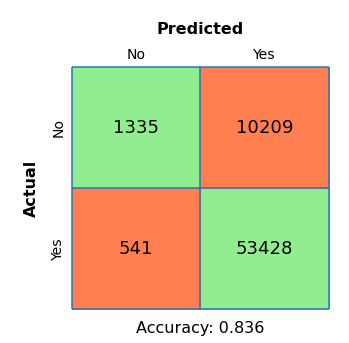

In [364]:
y_pred = forest.predict(X_test)
plot_confusion_matrix(y_test, y_pred, labels = ['No', 'Yes'], metric = 'accuracy')

In [365]:
roc_auc_score(y_test, forest.predict_proba(X_test)[:,1])

0.7937793098209263

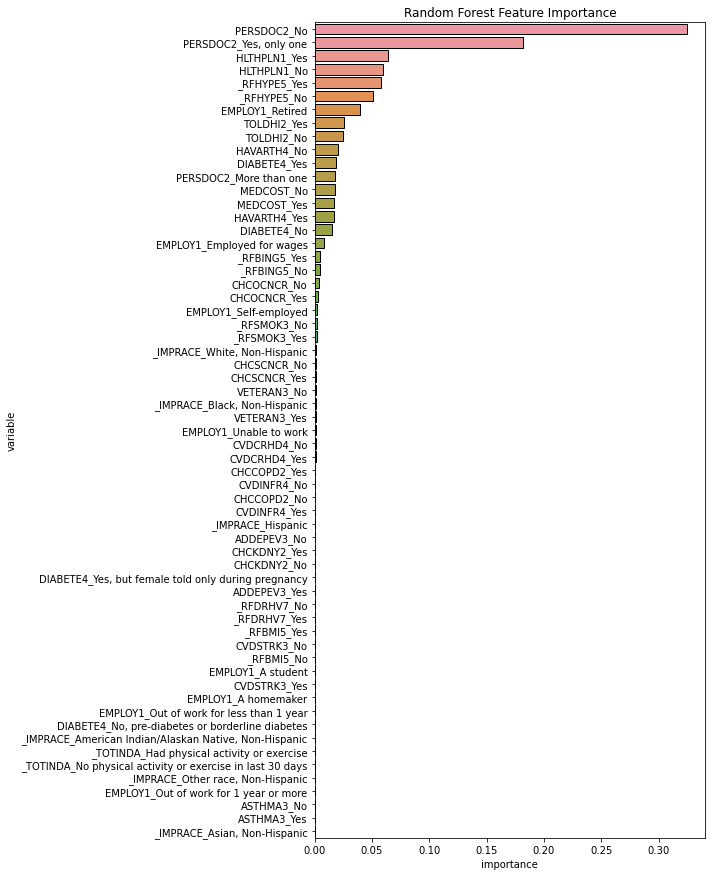

In [366]:
importances = pd.DataFrame({'variable': X.columns,
                           'importance': forest.feature_importances_}).sort_values('importance', ascending = False)


fig, ax = plt.subplots(figsize = (7,15))
sns.barplot(data = importances,
            x = 'importance', y = 'variable', ax = ax, edgecolor = 'black')
plt.title('Random Forest Feature Importance');

In [ ]:
X_test = 
y_test = 
y_pred = forest.predict(X_test)
plot_confusion_matrix(y_test, y_pred, labels = ['No', 'Yes'], metric = 'accuracy')